In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
sns.set_context('paper')
sns.set_style("white")
sns.set_style('ticks')
#sns.plt.style.use(['seaborn-ticks', 'seaborn-paper'])
sns.plt.rcParams['text.usetex'] = True
sns.plt.rcParams['text.latex.preamble'] = [r'\usepackage{lmodern}']
figure_width=6
boxplot_kwargs={'fliersize':4}

In [110]:
# raw results
comparison = pd.read_pickle('../results_horseshoe_p0set_vs_unset/performance_comparison.pck')
comparison.drop(['Parametrization', 'Hyperprior', 'Type', 'Nu'], axis=1, inplace=True)
comparison['p0 set'] = ~(comparison['Model p0'] == -1)

dataset_parameters = comparison.columns[:5].tolist()
model_parameters = [comparison.columns[5], 'p0 set']


# sampler statistics
sampler_stats = pd.read_pickle('../results_horseshoe_p0set_vs_unset/sampler_statistics.pck')
sampler_stats.drop(['Parametrization', 'Hyperprior', 'Type', 'Nu'], axis=1, inplace=True)
sampler_stats['p0 set'] = ~(sampler_stats['Model p0'] == -1)

In [109]:
model_parameters

['Model p0']

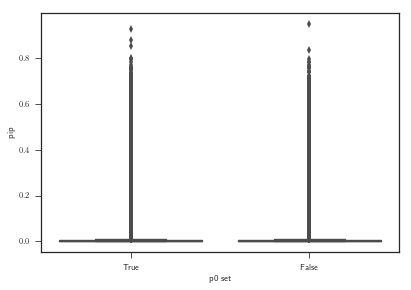

In [62]:
pip = comparison[comparison.Variable == 'pip'].copy()
pip.rename(columns={'Prediction (mean)': 'predicted', 'Prediction (std)': 'pip'}, inplace=True)
pip['']
sns.boxplot(data=pip, x='p0 set', y='pip', order=[True, False])

In [63]:
print((pip.loc[pip['p0 set'], 'pip'] > 0.5).sum(), (pip.loc[~pip['p0 set'], 'pip'] > 0.5).sum())

1273 1265


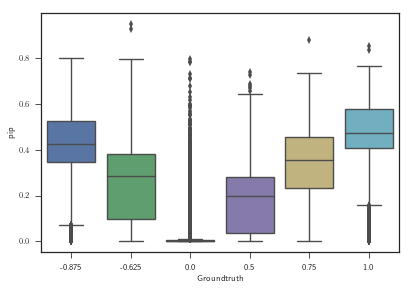

In [132]:
sns.boxplot(data=pip, x='Groundtruth', y='pip')

This is unexpected, would suggest that having a higher value for the tau0 prior leads to more variables being selected due to higher overall shrinkage
 * compare estimated values of tau
 * do scatter with aligned pip between both methods

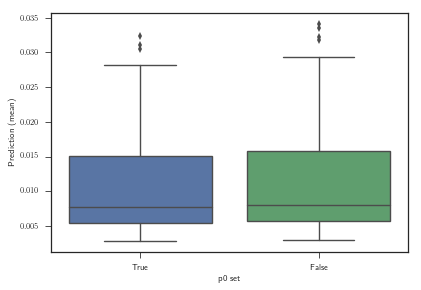

In [64]:
tau = comparison[comparison.Variable == 'tau']
sns.boxplot(data=tau, x='p0 set', y='Prediction (mean)', order=[True, False])

Interesting, the definition of p0 does not seem to have a large influence on estimated tau

In [96]:
from collections import OrderedDict
def compare_pip(data):
    p0set_sel = data['p0 set'].values
    p0set = data[p0set_sel]['pip'].values.flatten()
    gt_p0set = ~(data[p0set_sel]['Groundtruth']==0).values.flatten()
    
    p0notset = data[~p0set_sel]['pip'].values.flatten()
    gt_p0notset = ~(data[~p0set_sel]['Groundtruth']==0).values.flatten()
    assert np.all(gt_p0set == gt_p0notset)
    columns = OrderedDict()
    for col in dataset_parameters:
        columns[col] = [data[col].unique()[0]]*len(p0set)
    columns['pip p0set'] = p0set
    columns['pip p0unset'] = p0notset
    columns['Groundtruth'] = gt_p0set
    return pd.DataFrame(columns)
    
aligned_pip = pip.groupby(dataset_parameters, as_index=False).apply(compare_pip).reset_index().drop(['level_0', 'level_1'], axis=1)
aligned_pip.head()

,OTUs,Covariates,Data p0,Samples,Repetition,pip p0set,pip p0unset,Groundtruth
0,40,10,20,20,1,0.112813,0.122687,True
1,40,10,20,20,1,0.470707,0.461474,True
2,40,10,20,20,1,0.077615,0.097139,True
3,40,10,20,20,1,0.072201,0.075339,True
4,40,10,20,20,1,0.024249,0.028102,True


In [125]:
only_rep1 = aligned_pip[aligned_pip.Repetition == 1]
only_rep2 = aligned_pip[aligned_pip.Repetition == 2]

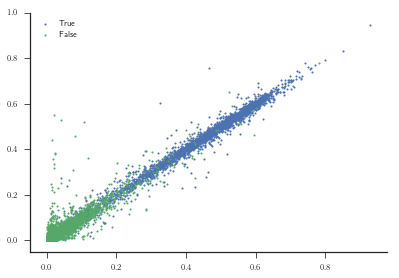

In [128]:
dataset = only_rep2
sns.plt.scatter(dataset[dataset.Groundtruth == True]['pip p0set'], dataset[dataset.Groundtruth == True]['pip p0unset'], label='True', s=3)
sns.plt.scatter(dataset[dataset.Groundtruth == False]['pip p0set'], dataset[dataset.Groundtruth == False]['pip p0unset'], label='False', s=3)
sns.plt.legend()
sns.despine()


Estimates of pip differ slightly

In [70]:
def align_taus(data):
    p0set = data['p0 set'].copy()
    data = data.drop(['Variable', 'Groundtruth', 'p0 set', 'Model', 'Model p0', 'Dataset'], axis=1)
    taup0set = data[p0set].copy()
    taup0set.rename(columns={'Prediction (mean)': 'tau p0set'}, inplace=True)
    taup0unset = data[~p0set].copy()
    taup0unset.rename(columns={'Prediction (mean)': 'tau p0unset'}, inplace=True)
    return pd.merge(taup0set, taup0unset, on=dataset_parameters+model_parameters[:-1])
aligned_taus = align_taus(tau)
aligned_taus.head()

,OTUs,Covariates,Data p0,Samples,Repetition,tau p0set,Prediction (std)_x,tau p0unset,Prediction (std)_y
0,40,50,25,100,1,0.004470,0.000822,0.004728,0.000853
1,80,30,45,100,1,0.008508,0.001238,0.008929,0.001199
2,120,50,65,20,1,0.006436,0.001322,0.006873,0.001389
3,80,50,45,180,1,0.004448,0.000598,0.004602,0.000626
4,80,30,45,220,1,0.005558,0.000787,0.005808,0.000804


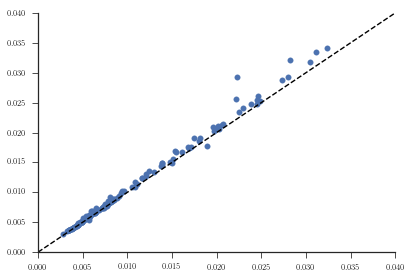

In [130]:
#ax = sns.plt.subplot()
sns.plt.scatter(aligned_taus['tau p0set'], aligned_taus['tau p0unset'])
dmin=0
dmax=0.04
sns.plt.plot([dmin, dmax], [dmin, dmax], 'k--')
sns.plt.xlim((dmin, dmax))
sns.plt.ylim((dmin, dmax))
sns.despine()

$\tau$ is correctly estimated although only a very vague prior is given (Cauchy, beta=1)

### Compute MCC 

In [111]:
def compute_confusion_matrix(data):
    predicted = data['Prediction (mean)'].astype(bool)
    gt = data['Groundtruth'].astype(bool)
    TP = np.sum(predicted & gt)
    TN = np.sum((~predicted) & (~gt))
    FP = np.sum(predicted & (~gt))
    FN = np.sum((~predicted) & gt)
    N = TP + TN + FP + FN
    return pd.Series({'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'N':N})

include_covariate = comparison[comparison.Variable == 'include_covariate']
confusion_parameters = include_covariate.groupby(dataset_parameters+model_parameters).apply(compute_confusion_matrix).reset_index()
p = confusion_parameters
confusion_parameters['MCC'] = (p.TP*p.TN - p.FN*p.FP)/np.sqrt((p.TP + p.FP)*(p.TP + p.FN)*(p.TN + p.FP)*(p.TN + p.FN))

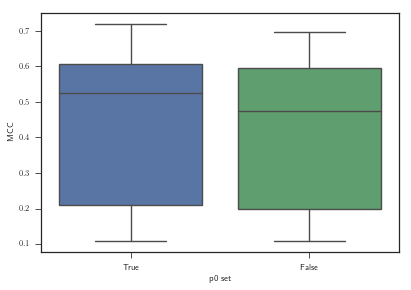

In [113]:
sns.boxplot(data=confusion_parameters, x='p0 set', y='MCC', order=[True, False])

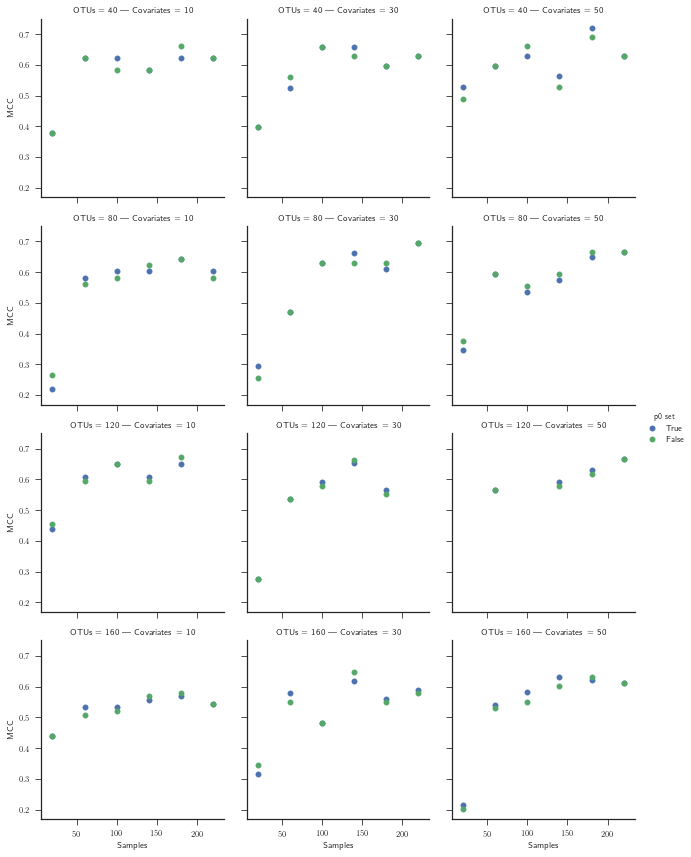

In [122]:
confusion_parameters_rep1 = confusion_parameters[confusion_parameters.Repetition == 2]
g = sns.FacetGrid(data=confusion_parameters_rep1, col='Covariates', row='OTUs', hue='p0 set', legend_out=True, hue_order=[True, False])
g.map(sns.plt.scatter, 'Samples', 'MCC')
g.add_legend()

In [120]:
confusion_parameters

,OTUs,Covariates,Data p0,Samples,Repetition,Model p0,p0 set,FN,FP,N,TN,TP,MCC
0,40,10,20,20,1,-1,False,19,0,400,380,1,0.218218
1,40,10,20,20,1,20,True,19,0,400,380,1,0.218218
2,40,10,20,20,2,-1,False,17,0,400,380,3,0.378915
3,40,10,20,20,2,20,True,17,0,400,380,3,0.378915
4,40,10,20,60,1,-1,False,20,0,400,380,0,NaN
5,40,10,20,60,1,20,True,20,0,400,380,0,NaN
6,40,10,20,60,2,-1,False,12,0,400,380,8,0.622700
7,40,10,20,60,2,20,True,12,0,400,380,8,0.622700
8,40,10,20,100,1,-1,False,20,0,400,380,0,NaN
9,40,10,20,100,1,20,True,20,0,400,380,0,NaN
